# Implementation and Visualizations of Pinet and FSnet

In [1]:
import sys
import os

# Make sure the project root is on sys.path
project_root = os.path.abspath("../")  # adjust if notebook is in a subfolder
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    src = os.path.join(project_root, "src")
    sys.path.insert(0, src)

print("Added to sys.path:", project_root)
print("Added to sys.path:", src)

# Set WANDB offline if just want to run locally
# os.environ["WANDB_MODE"] = "offline"

Added to sys.path: /home/goiv/SafeGBPO_main_3/SafeGBPO
Added to sys.path: /home/goiv/SafeGBPO_main_3/SafeGBPO/src


## Pinet

In [ ]:
from conf.envs import *
from conf.safeguard import *
from conf.learning_algorithms import *
from src.main import run_experiment, Experiment

import wandb
import torch
import optuna
import csv
from pathlib import Path

torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

wandb.login(key="") # Insert login key

experiment_queue = [
    Experiment(num_runs=1,
                learning_algorithm=SHACConfig(),
                env=NavigateSeekerConfig(safe_action_polytope=True),
                safeguard=PinetConfig(n_iter_admm=100, n_iter_bwd=5, fpi=True),
                interactions=100_000,
                eval_freq=5_000,
                fast_eval=False),
]

csv_path = Path("src/runs_ids.csv")

# Create file and header ONLY if it does not exist
if not csv_path.exists():
    with open(csv_path, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["run_index", "safeguard", "wandb_run_id"])


for i, experiment in enumerate(experiment_queue):
    if experiment.num_runs == 0:
        print("[STATUS] Running hyperparameter search")
        study = optuna.create_study(direction="maximize",
                                    sampler=optuna.samplers.TPESampler(),
                                    pruner=optuna.pruners.HyperbandPruner(),
                                    storage=f"sqlite:///hyperparameters/{experiment.env.name}/study.sqlite3",
                                    study_name=experiment.learning_algorithm.name)

        pre_valued_objective = lambda trial: run_experiment(experiment, trial)
        study.optimize(pre_valued_objective, n_trials=100, n_jobs=1)
        print(f"Best value: {study.best_value} (params: {study.best_params})")

    else:
        print(f"[STATUS] Running experiment [{i + 1}/{len(experiment_queue)}]")
        for j in range(experiment.num_runs):
            print(f"  → Run {j + 1}/{experiment.num_runs}")

            _, run_id = run_experiment(experiment)

            # Save the run_id to download data from it later for visualizations
            with open(csv_path, mode="a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([j, experiment.safeguard.name if experiment.safeguard else "None", run_id])


### Extra Documentation for Pinet

**Implicit differentiation for ADMM fixed-point layer**

We consider an ADMM solver that produces s_k as a fixed point:

$$s_k = \text{ADMM}(s_k, a)$$

Define the implicit function:

$$F(s_k, a) = s_k - \text{ADMM}(s_k, a) = 0$$

We want the total derivative:

$$\frac{ds_k}{da}$$

By the implicit function theorem:

$$
\frac{ds_k}{da} = - \left(\frac{dF}{ds_k}\right)^{-1} \cdot \frac{dF}{da}
= \left(I - \frac{d\text{ADMM}(s_k, a)}{ds_k}\right)^{-1} \cdot \frac{d\text{ADMM}(s_k, a)}{da}
$$

Let the loss be L. By the chain rule:

$$
\frac{dL}{da} = \frac{dL}{da_{safe}} · \frac{da_{safe}}{ds_k} · \frac{ds_k}{da}
$$

Substitute the implicit derivative:

$$
\frac{dL}{da} = \frac{dL}{da_{safe}} · \frac{da_{safe}}{ds_k} · \left(I - \frac{d\text{ADMM}(s_k, a)}{ds_k}\right)^{-1} \cdot \frac{d\text{ADMM}(s_k, a)}{da}
$$

Define:

$$
v = \frac{dL}{da_{safe}} · \frac{da_{safe}}{ds_k}
$$

Then we solve the linear system:

$$
\left(I - \frac{d\text{ADMM}(s_k, a)}{ds_k}\right) g = v
$$

This can be done using:

- **Fixed-point iteration**:

$$
g_{k+1} = v + \frac{d\text{ADMM}(s_k, a)}{ds_k}^T g_k
$$

- **Or Anderson-style relaxed iteration**.

Finally, compute the gradient with respect to a:

$$
\frac{dL}{da} = g^T · \frac{d\text{ADMM}(s_k, a)}{da}
$$

**Implementation outline:**

1. Project upstream gradient to lifted space via zero-padding.
2. Compute $v = \frac{dL}{da_{safe}} · \frac{da_{safe}}{ds_k}$ via VJP.
3. Solve the linear system for g using JVP/VJP iterations.
4. Compute $\frac{d\text{ADMM}(s_k, a)}{da}$ via JVP and contract with g.
5. Return the gradient.


## FSnet

## Visualizations

### Result and Time Comparison Graphs

In [2]:
import pandas as pd
import wandb
from pathlib import Path
import numpy as np

# ------------------ CONFIG ------------------
CSV_PATH = Path("runs_ids.csv")
PROJECT_NAME = "Leveraging Analytical Gradients in Provably Safe Reinforcement Learning"
OUTPUT_CSV = Path("wandb_time_series.csv")
METRICS = ["eval/Average Reward", "performance_train/steps_per_second"]
# -------------------------------------------

def create_csv():
    assert CSV_PATH.exists(), f"{CSV_PATH} not found"

    # Read run IDs
    df_ids = pd.read_csv(CSV_PATH)
    run_ids = df_ids["wandb_run_id"].tolist()
    methods = df_ids["safeguard"].tolist()
    print(f"[INFO] Found {len(run_ids)} runs in runs_ids.csv")

    if OUTPUT_CSV.exists():
        df_existing = pd.read_csv(OUTPUT_CSV)
        existing_run_ids = set(df_existing["run_id"].unique())
        print(f"[INFO] Found {len(existing_run_ids)} runs already in {OUTPUT_CSV}")
    else:
        df_existing = None
        existing_run_ids = set()
        print(f"[INFO] {OUTPUT_CSV} does not exist yet. Will create it.")

    api = wandb.Api()
    all_new_rows = []

    for idx, (run_id, method) in enumerate(zip(run_ids, methods)):
        if run_id in existing_run_ids:
            print(f"[{idx + 1}/{len(run_ids)}] Skipping run {run_id} (already in CSV)")
            continue

        print(f"[{idx + 1}/{len(run_ids)}] Fetching run {run_id}")

        try:
            run = api.run(f"{PROJECT_NAME}/{run_id}")
        except wandb.errors.CommError as e:
            print(f"[WARNING] Could not load run {run_id}: {e}")
            continue

        history = run.history(keys=METRICS)

        if history is None or len(history) == 0:
            print(f"[WARNING] No history for run {run_id}")
            continue

        history["run_id"] = run.id
        history["Safeguard"] = method if isinstance(method, str) else "No Safeguard"

        cols = ["run_id", "Safeguard", "_step"] + METRICS
        history = history[cols]

        all_new_rows.append(history)

    if all_new_rows:
        df_new = pd.concat(all_new_rows, axis=0).reset_index(drop=True)

        if df_existing is not None:
            df_all = pd.concat([df_existing, df_new], axis=0).reset_index(drop=True)
        else:
            df_all = df_new

        df_all.to_csv(OUTPUT_CSV, index=False)
        print(f"[DONE] Added {len(df_new['run_id'].unique())} new runs to {OUTPUT_CSV}")
    else:
        print("[INFO] No new runs to add. Everything is already up to date.")

create_csv()

[INFO] Found 267 runs in runs_ids.csv
[INFO] Found 267 runs already in wandb_time_series.csv
[1/267] Skipping run ci1jab90 (already in CSV)
[2/267] Skipping run yglnimc5 (already in CSV)
[3/267] Skipping run wiyj6ayv (already in CSV)
[4/267] Skipping run 9l06u48e (already in CSV)
[5/267] Skipping run ry67tgnh (already in CSV)
[6/267] Skipping run xgiwneih (already in CSV)
[7/267] Skipping run h1cvcdvl (already in CSV)
[8/267] Skipping run 63s69d2t (already in CSV)
[9/267] Skipping run ek15uayd (already in CSV)
[10/267] Skipping run 8l1r5d3x (already in CSV)
[11/267] Skipping run j4z0g909 (already in CSV)
[12/267] Skipping run finserbk (already in CSV)
[13/267] Skipping run 2pscuap7 (already in CSV)
[14/267] Skipping run v3qv2i0p (already in CSV)
[15/267] Skipping run d0lker1h (already in CSV)
[16/267] Skipping run 1334lb2a (already in CSV)
[17/267] Skipping run lo1vy1zx (already in CSV)
[18/267] Skipping run v08z9stn (already in CSV)
[19/267] Skipping run s4s991uk (already in CSV)
[20/

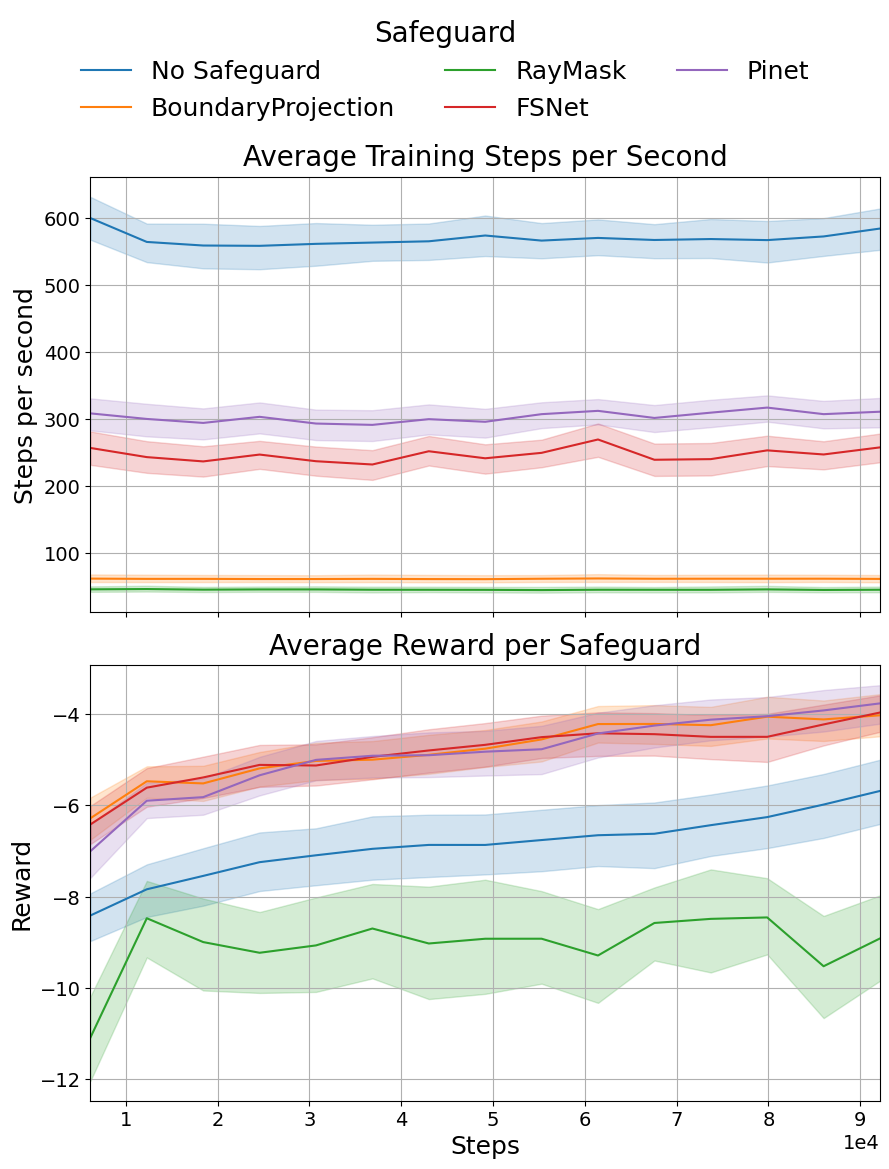

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load CSVs
df = pd.read_csv("wandb_time_series.csv")

first_step = min(df["_step"].min(), df["_step"].min())
last_step  = max(df["_step"].max(), df["_step"].max())

sns.color_palette("Dark2")

# Create stacked subplots
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(9, 11),
    sharex=True
)

# --------- TOP PLOT: Steps per second ---------
sns.lineplot(
    data=df,
    x="_step",
    y="performance_train/steps_per_second",
    hue="Safeguard",
    estimator="mean",
    errorbar=("ci", 95),
    lw=1.5,
    ax=ax1
)

ax1.set_xlim(first_step, last_step)
ax1.set_ylabel("Steps per second", fontsize=18)
ax1.set_title("Average Training Steps per Second", fontsize=20, pad=8)
ax1.grid(True)

# Remove legend from top plot (we'll use bottom one)
ax1.get_legend().remove()

# --------- BOTTOM PLOT: Reward ---------
sns.lineplot(
    data=df,
    x="_step",
    y="eval/Average Reward",
    hue="Safeguard",
    estimator="mean",
    errorbar=("ci", 95),
    lw=1.5,
    ax=ax2
)

ax2.set_xlim(first_step, last_step)
ax2.set_xlabel("Steps", fontsize=18)
ax2.set_ylabel("Reward", fontsize=18)
ax2.set_title("Average Reward per Safeguard", fontsize=20, pad=8)
ax2.grid(True)

# Scientific notation for shared x-axis
ax2.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# --------- Shared legend ---------
# --------- Shared legend at top ---------
handles, labels = ax2.get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Safeguard",
    title_fontsize=20,
    fontsize=18,
    loc="upper center",
    ncol=3,          # put entries in one row
    frameon=False,
    bbox_to_anchor=(0.5, 1.07)
)

# Remove seaborn legends from axes
ax2.get_legend().remove()

for ax in (ax1, ax2):
    ax.tick_params(axis='both', labelsize=14)
    ax.xaxis.get_offset_text().set_fontsize(14)

# Layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save
plt.savefig(
    "./combined_training_and_reward.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True
)

plt.show()
